In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score, cohen_kappa_score, fbeta_score
from yellowbrick.classifier import ClassificationReport, ConfusionMatrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler
import scikitplot as skplt

In [2]:
df = pd.read_csv('./healthcare-dataset-stroke-data.csv')

In [3]:
df_dum = pd.get_dummies(df.drop(columns=['id']), columns=['gender', 'hypertension', 'heart_disease', 'ever_married', 
                                     'work_type', 'Residence_type', 'smoking_status'])

X = df_dum.drop('stroke', axis=1)
y = df_dum.stroke.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=df_dum.stroke.values)

In [4]:
imp = SimpleImputer(missing_values=np.nan, strategy="mean")
X_train["bmi"] = imp.fit_transform(X_train[["bmi"]]).ravel()

/Users/koraykarakas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [5]:
oversample = SMOTE(random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)

In [6]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)

In [7]:
neigh = KNeighborsClassifier(n_neighbors=2)
neigh.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

In [8]:
X_test["bmi"] = imp.transform(X_test[["bmi"]]).ravel()

/Users/koraykarakas/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [9]:
X_test = scaler.transform(X_test)

In [10]:
y_pred = neigh.predict(X_test)

In [11]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97       972
           1       0.25      0.04      0.07        50

    accuracy                           0.95      1022
   macro avg       0.60      0.52      0.52      1022
weighted avg       0.92      0.95      0.93      1022



In [12]:
print(classification_report(y_train, neigh.predict(X_train)))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      3889
           1       1.00      0.96      0.98      3889

    accuracy                           0.98      7778
   macro avg       0.98      0.98      0.98      7778
weighted avg       0.98      0.98      0.98      7778



In [13]:
print('test set', accuracy_score(y_test, y_pred))
print('train set', accuracy_score(y_train, neigh.predict(X_train)))

test set 0.9471624266144814
train set 0.98032913345333


In [14]:
params = {'n_neighbors': range(2, 15)}


gs = GridSearchCV(neigh, params, scoring='f1', cv=3,  n_jobs=-1, verbose=10)
gs.fit(X_train, y_train)

Fitting 3 folds for each of 13 candidates, totalling 39 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(n_neighbors=2), n_jobs=-1,
             param_grid={'n_neighbors': range(2, 15)}, scoring='f1',
             verbose=10)

In [15]:
gs.best_params_

{'n_neighbors': 2}

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

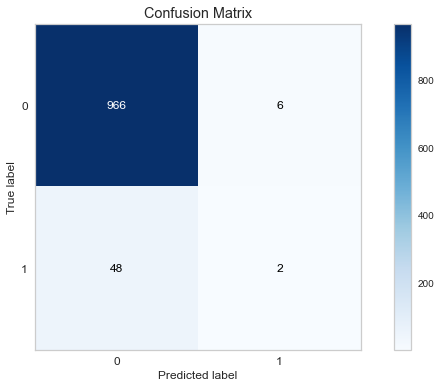

In [16]:
skplt.metrics.plot_confusion_matrix(y_test, y_pred, figsize=(12, 6))

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

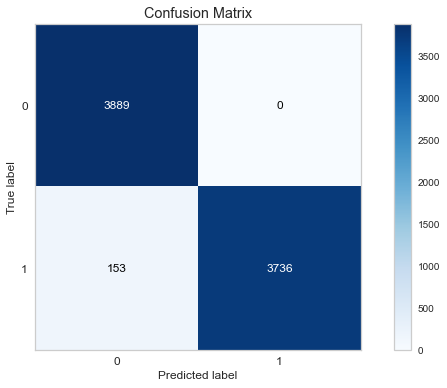

In [17]:
skplt.metrics.plot_confusion_matrix(y_train, neigh.predict(X_train), figsize=(12, 6))

In [18]:
print('train set', fbeta_score(y_train, neigh.predict(X_train), beta=2.0))
print('test set', fbeta_score(y_test, y_pred, beta=2.0))

train set 0.9682770060128549
test set 0.04807692307692308


In [19]:
print('train set', cohen_kappa_score(y_train, neigh.predict(X_train)))
print('test set', cohen_kappa_score(y_test, y_pred))

train set 0.9606582669066598
test set 0.056228196183049306


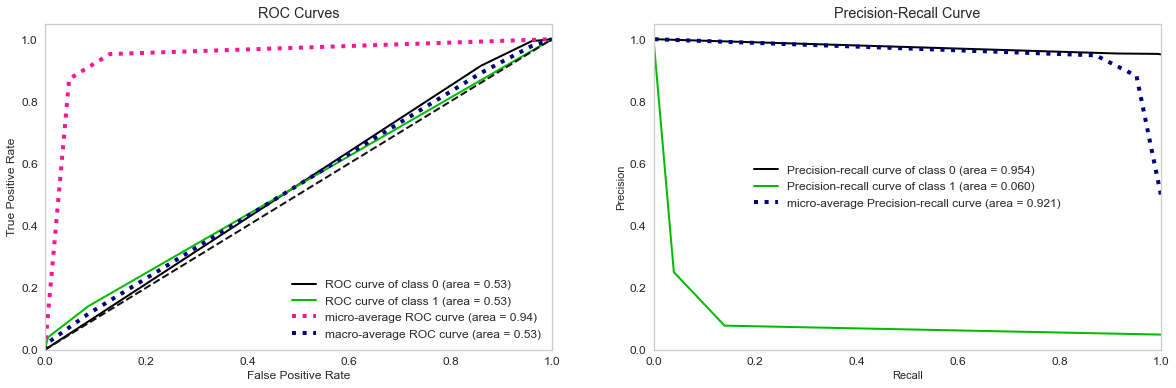

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
skplt.metrics.plot_roc(y_test, neigh.predict_proba(X_test), figsize=(10, 6), ax=ax1)
skplt.metrics.plot_precision_recall(y_test, neigh.predict_proba(X_test), figsize=(10, 6), ax=ax2)
ax1.grid()
ax2.grid()